## Malware Exploratory Notebook - Cybersecutiry Data Science - 2020/1
#### Luiz Henrique de Melo Santos

Basically, I promoted new data treatments, such as One-Hot and normalization, and used a more accurate learning algorithm for the problem, the LightGBM, from Google.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
RANDOM_STATE = 42

/kaggle/input/malware/malware.csv


### Data import

In [2]:
#In this section we use a labeled malware dataset. 
#The malware dataset contains features extracted from the following:
#41,323 Windows binaries (executables .exe and .dlls), as legitimate files.
#96,724 malware files downloaded from the VirusShare website. So, the dataset
# contains 138,048 lines, in total.

MalwareDataset = pd.read_csv('/kaggle/input/malware/malware.csv', sep='|')

### Quick-view of data

In [3]:
# To make sure that the dataset has loaded properly, let's print the number of important features:
print('The Number of important features is %i \n' % (MalwareDataset.shape[1]-1))

The Number of important features is 56 



In [4]:
MalwareDataset.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1


[]

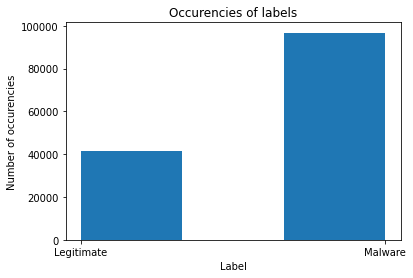

In [5]:
# looking for class distribution
classes = MalwareDataset['legitimate'].map({0:'Malware',1:'Legitimate'}).sort_values()
plt.xlabel('Label')
plt.ylabel('Number of occurencies')
plt.title('Occurencies of labels')
plt.hist(classes, bins=3)
plt.plot()

### Data treatment

In [6]:
# check for NaN values
print(MalwareDataset.isnull().sum().sum())

0


In [7]:
# removing non-relevant features
MalwareDataset = MalwareDataset.drop(['Name', 'md5'], axis=1)

In [8]:
# looking for unique values per column
MalwareDataset.nunique()

Machine                            3
SizeOfOptionalHeader               5
Characteristics                  104
MajorLinkerVersion                41
MinorLinkerVersion                62
SizeOfCode                      3809
SizeOfInitializedData           3217
SizeOfUninitializedData          441
AddressOfEntryPoint            23110
BaseOfCode                       385
BaseOfData                      1106
ImageBase                       9099
SectionAlignment                  12
FileAlignment                      9
MajorOperatingSystemVersion       12
MinorOperatingSystemVersion       12
MajorImageVersion                 38
MinorImageVersion                 70
MajorSubsystemVersion              6
MinorSubsystemVersion             10
SizeOfImage                     2312
SizeOfHeaders                     30
CheckSum                       81633
Subsystem                          4
DllCharacteristics                74
SizeOfStackReserve                40
SizeOfStackCommit                 40
S

In [9]:
# apply One-Hot Encoder
MalwareDataset = pd.concat([MalwareDataset, pd.get_dummies(MalwareDataset.Machine, prefix='Machine')], axis=1).drop(['Machine'], axis=1)
MalwareDataset = pd.concat([MalwareDataset, pd.get_dummies(MalwareDataset.SizeOfOptionalHeader, prefix='SizeOfOptionalHeader')], axis=1).drop(['SizeOfOptionalHeader'], axis=1)
MalwareDataset = pd.concat([MalwareDataset, pd.get_dummies(MalwareDataset.Subsystem, prefix='Subsystem')], axis=1).drop(['Subsystem'], axis=1)
MalwareDataset = pd.concat([MalwareDataset, pd.get_dummies(MalwareDataset.FileAlignment, prefix='FileAlignment')], axis=1).drop(['FileAlignment'], axis=1)

In [10]:
# define features and target
target = 'legitimate'
features = MalwareDataset.columns.to_list()
features.remove(target)

MalwareDataset.shape

(138047, 72)

In [11]:
# normalization of features
MalwareDataset[features] = (MalwareDataset[features]-MalwareDataset[features].mean())/MalwareDataset[features].std()

In [12]:
MalwareDataset.head()

,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,...,Subsystem_16,FileAlignment_16,FileAlignment_32,FileAlignment_64,FileAlignment_128,FileAlignment_512,FileAlignment_1024,FileAlignment_2048,FileAlignment_4096,FileAlignment_65536
0,-0.511330,0.092993,-0.321958,0.020747,-0.015930,-0.006173,-0.048337,-0.009715,0.069177,-0.005389,...,59.486478,-0.004662,-0.017236,-0.003806,-0.027851,0.223933,-0.010424,-0.002691,-0.220252,-0.016151
1,-0.136091,0.092993,-0.321958,-0.019469,-0.020485,-0.006173,-0.026287,-0.009715,-0.035655,-0.005389,...,-0.016810,-0.004662,-0.017236,-0.003806,-0.027851,0.223933,-0.010424,-0.002691,-0.220252,-0.016151
2,-0.136091,0.092993,-0.321958,0.047706,0.008141,-0.006173,0.052161,-0.009715,0.269483,-0.005389,...,-0.016810,-0.004662,-0.017236,-0.003806,-0.027851,0.223933,-0.010424,-0.002691,-0.220252,-0.016151
3,-0.511330,0.092993,-0.321958,0.059629,-0.003870,-0.006173,0.081416,-0.009715,0.263867,-0.005389,...,-0.016810,-0.004662,-0.017236,-0.003806,-0.027851,0.223933,-0.010424,-0.002691,-0.220252,-0.016151
4,-0.511330,0.092993,-0.321958,0.009091,-0.009668,-0.006173,0.013241,-0.009715,0.144058,-0.005389,...,-0.016810,-0.004662,-0.017236,-0.003806,-0.027851,0.223933,-0.010424,-0.002691,-0.220252,-0.016151


In [13]:
# define features and targets
X = MalwareDataset[features]
y = MalwareDataset[target]

### Feature Selection

In [14]:
FeatSelect = ExtraTreesClassifier(n_jobs=-1, n_estimators=400, random_state=RANDOM_STATE).fit(X,y)
md = SelectFromModel(FeatSelect, prefit=True)
X_new = md.transform(X)
print(X.shape)
print(X_new.shape)

(138047, 71)
(138047, 14)


In [15]:
# Feature importance - So, the algorithms has selected fifteen important features for us
features_new = X_new.shape[1]
index = np.argsort(ExtraTreesClassifier(n_jobs=-1, n_estimators=400, random_state=RANDOM_STATE).fit(X,y).feature_importances_)[::-1][:features_new]
features.clear()
for feat in range(features_new):
    features.append(MalwareDataset.columns[2+index[feat]])
features

['Subsystem_3',
 'Subsystem_16',
 'SizeOfStackCommit',
 'MinorLinkerVersion',
 'Machine_512',
 'SizeOfOptionalHeader_248',
 'Machine_332',
 'SizeOfOptionalHeader_232',
 'SizeOfImage',
 'SizeOfOptionalHeader_224',
 'SectionsMinRawsize',
 'ResourcesMinSize',
 'ResourcesMeanSize',
 'MajorImageVersion']

In [16]:
# train/test/validation split
X = MalwareDataset[features]  # updating features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, stratify=y_test, random_state=RANDOM_STATE)

### Fine tuning in LightGBM using Grid Search and Cross-Validation

In [17]:
# define params to be used
params = {'metric': ['auc'],
          'num_threads': [-1],
          'force_col_wise': [True],
          'verbosity': [-1],
          'seed': [RANDOM_STATE],
          'is_unbalance': [True],
          # From fine-tuning
          'max_depth': [-1, 10, 20],
          'n_estimators': [50, 100, 200],
          'min_child_samples': [10, 20],
          'learning_rate': [0.001, 0.01, 0.1],
          'subsample': [0.4, 0.92],
          'log_max_bin': [5, 8],
          'scale_pos_weight': [0.4, 1]}

In [18]:
# Fine-Tune LightGBM algorithm, using AUC-ROC to evaluate model
md = lgb.LGBMClassifier()
clf = GridSearchCV(md, params, scoring='roc_auc', verbose=4, n_jobs=-1, cv=5, refit=False, return_train_score=True)
clf.fit(X,y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 15.9min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'force_col_wise': [True], 'is_unbalance': [True],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'log_max_bin': [5, 8], 'max_depth': [-1, 10, 20],
                         'metric': ['auc'], 'min_child_samples': [10, 20],
                         'n_estimators': [50, 100, 200], 'num_threads': [-1],
                         'scale_pos_weight': [0.4, 1], 'seed': [42],
                         'subsample': [0.4, 0.92], 'verbosity': [-1]},
             refit=False, return_train_score=True, scoring='roc_auc',
             verbose=4)

In [19]:
# print results
print('> Best params:', clf.best_params_, '\n', '> Best score:', clf.best_score_)

> Best params: {'force_col_wise': True, 'is_unbalance': True, 'learning_rate': 0.1, 'log_max_bin': 5, 'max_depth': -1, 'metric': 'auc', 'min_child_samples': 20, 'n_estimators': 200, 'num_threads': -1, 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.4, 'verbosity': -1} 
 > Best score: 0.9979230835402471


### Train final model

In [20]:
# define parameters of final model
params = {'force_col_wise': True,
          'is_unbalance': True,
          'learning_rate': 0.1,
          'max_depth': -1,
          'metric': 'auc',
          'min_child_samples': 20,
          'n_estimators': 200,
          'num_threads': -1,
          'scale_pos_weight': 1,
          'seed': RANDOM_STATE,
          'subsample': 0.4,
          'verbosity': -1}

# train the model
model = lgb.LGBMClassifier(**params).fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
clear_output(wait=False)

### Evaluation on validation data

In [21]:
# make prediction and probabilistic prediction on validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)

<AxesSubplot:title={'center':'AUC during training'}, xlabel='Number of estimators', ylabel='AUC'>

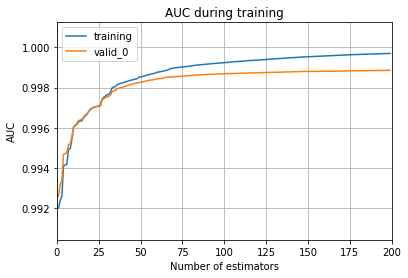

In [22]:
# metrics during training plot
lgb.plot_metric(model, title='AUC during training', xlabel='Number of estimators', ylabel='AUC')

[]

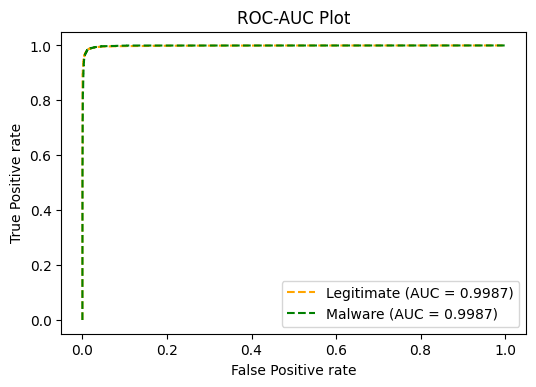

In [23]:
# ROC-AUC plot

fpr = {}
tpr = {}
thresh ={}
roc_auc = []
n_class = 2

# evaluate FPR/TPR for each class
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_val, y_pred_proba[:,i], pos_label=i)
    roc_auc.append(metrics.auc(fpr[i], tpr[i]))
plt.figure(dpi=100)

# for each class
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Legitimate (AUC = {1:0.4f})'.format(i, roc_auc[0]))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Malware (AUC = {1:0.4f})'.format(i, roc_auc[1]))

# plot
plt.title('ROC-AUC Plot')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.plot()

In [24]:
# accuracy score
metrics.accuracy_score(y_val, y_pred)

0.9869612459253894

In [25]:
# F1-Score
print('F1 micro:',metrics.f1_score(y_val, y_pred, average='micro'))
print('F1 macro:',metrics.f1_score(y_val, y_pred, average='macro'))

F1 micro: 0.9869612459253894
F1 macro: 0.9845144156688949
